In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pickle
file = open('dataset/dataset.pkl','rb')
DATA = pickle.load(file)
pheno = DATA['pheno']
X_gpa = DATA['X_gpa']
X_snps = DATA['X_snps']
X_genexp = DATA['X_genexp']
pheno.columns = [pheno.columns[0]] + ["TOB", "CAZ", "CIP", "MER", "COL"]
antibiotics = pheno.columns[1:]

In [5]:
import os
import ast
import pandas as pd

def process_results_csv_with_indices(directory):
    column_indices = {}

    # Parcourir les fichiers dans le répertoire dans l'ordre alphabétique
    for file_name in sorted(os.listdir(directory)):
        if file_name.startswith("result_") and file_name.endswith(".csv"):
            model_name = file_name[len("result_"):-4]  # Extraire le nom du modèle à partir du nom du fichier
            file_path = os.path.join(directory, file_name)

            # Lire le fichier CSV
            df = pd.read_csv(file_path, sep=';')
            df['Antibiotique'] = antibiotics
            for _, row in df.iterrows():
                antibiotic = row['Antibiotique']
                gpa_columns = ast.literal_eval(row['Colonnes_GPA'])
                snps_columns = ast.literal_eval(row['Colonnes_SNPs'])
                genexp_columns = ast.literal_eval(row['Colonnes_Expression_Genetique'])

                # Mettre à jour les indices des colonnes sélectionnées
                if antibiotic not in column_indices:
                    column_indices[antibiotic] = {}
                column_indices[antibiotic][model_name] = {
                    'GPA': gpa_columns,
                    'SNPs': snps_columns,
                    'GenExp': genexp_columns
                }

    column_indices_df = {}
    for col_type in ['GPA', 'SNPs', 'GenExp']:
        column_indices_df[col_type] = pd.DataFrame(
            {antibiotic: {model: data[col_type] for model, data in models.items()}
             for antibiotic, models in column_indices.items()}
        ).T

    return column_indices_df

column_indices_df = process_results_csv_with_indices('result')

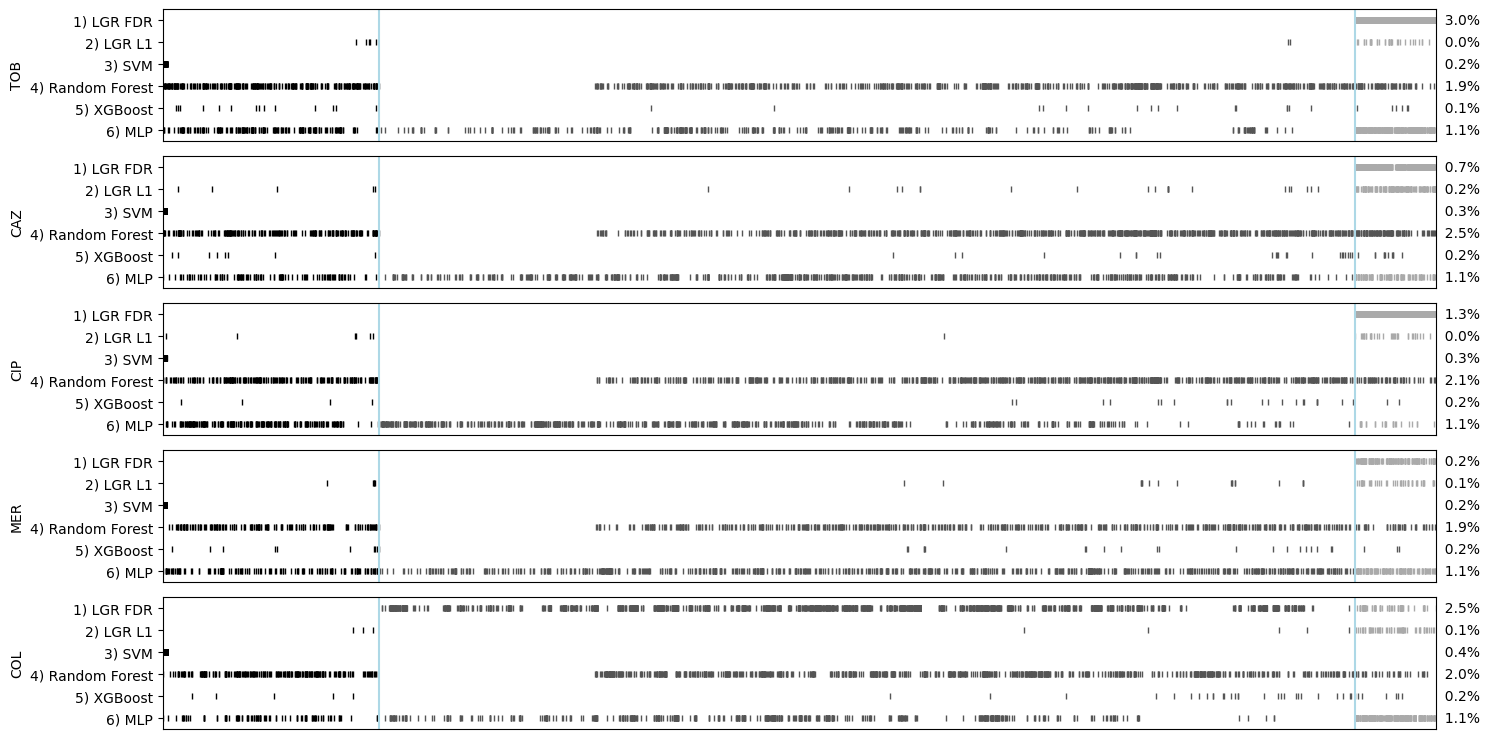

In [6]:
import numpy as np
import matplotlib.pyplot as plt

def plot_genetic_map(column_indices_df, X_gpa, X_snps, X_genexp):
    # Fusionner les colonnes en un tableau global
    total_columns = list(range(X_gpa.shape[1] + X_snps.shape[1] + X_genexp.shape[1]))
    col_break_gpa = X_gpa.shape[1]
    col_break_snps = X_gpa.shape[1] + X_snps.shape[1]

    # Créer une figure globale pour afficher tous les antibiotiques
    num_antibiotics = len(column_indices_df['GPA'].index)
    fig, axes = plt.subplots(num_antibiotics, 1, figsize=(15, num_antibiotics * 1.5))

    if num_antibiotics == 1:
        axes = [axes]  # S'assurer que les axes sont toujours itérables

    for ax, (antibiotic, models) in zip(axes, column_indices_df['GPA'].iterrows()):
        # Trier les modèles par ordre décroissant de nom
        sorted_models = models.sort_index(ascending=False)

        # Construire une matrice vide avec un fond blanc
        background_matrix = np.ones((len(sorted_models), len(total_columns)))
        ax.imshow(background_matrix, cmap=plt.cm.binary, extent=[0, len(total_columns), 0, len(sorted_models)], aspect='auto')

        # Ajouter des carrés colorés pour les colonnes sélectionnées
        marker_height = 0.3  # Réduire la hauteur
        marker_width = 1e-10   # Réduire la largeur

        for i, (model, gpa_columns) in enumerate(sorted_models.items()):
            # Récupérer les colonnes GPA, SNPs et GenExp pour ce modèle
            snps_columns = column_indices_df['SNPs'].at[antibiotic, model]
            genexp_columns = column_indices_df['GenExp'].at[antibiotic, model]

            for col in gpa_columns:
                ax.add_patch(plt.Rectangle((col, i + 0.5 - marker_height / 2), marker_width, marker_height, color='#000000'))  # GPA en noir
            for col in snps_columns:
                ax.add_patch(plt.Rectangle((col_break_gpa + col, i + 0.5 - marker_height / 2), marker_width, marker_height, color='#555555'))  # SNPs en gris moyen
            for col in genexp_columns:
                ax.add_patch(plt.Rectangle((col_break_snps + col, i + 0.5 - marker_height / 2), marker_width, marker_height, color='#AAAAAA'))  # GenExp en gris clair

            # Calculer les statistiques de colonnes sélectionnées
            total_selected = len(gpa_columns) + len(snps_columns) + len(genexp_columns)
            total_possible = X_gpa.shape[1] + X_snps.shape[1] + X_genexp.shape[1]
            percentage_selected = (total_selected / total_possible) * 100

            gpa_percentage = (len(gpa_columns) / X_gpa.shape[1]) * 100 if X_gpa.shape[1] > 0 else 0
            snps_percentage = (len(snps_columns) / X_snps.shape[1]) * 100 if X_snps.shape[1] > 0 else 0
            genexp_percentage = (len(genexp_columns) / X_genexp.shape[1]) * 100 if X_genexp.shape[1] > 0 else 0

            # Afficher les informations en bout de ligne avec une boîte colorée
            #summary_text = f"  {percentage_selected:.1f}% (GPA: {gpa_percentage:.1f}% | SNPs: {snps_percentage:.1f}% | GenExp: {genexp_percentage:.1f}%)"
            summary_text = f"  {percentage_selected:.1f}%"
            ax.text(len(total_columns) + 1, i + 0.5, summary_text, va='center', ha='left')

        # Ajouter des lignes de séparation entre les types de colonnes (en bleu)
        ax.axvline(col_break_gpa, color='lightblue', linewidth=1.5)
        ax.axvline(col_break_snps, color='lightblue', linewidth=1.5)

        # Configurer les axes
        ax.set_yticks(np.arange(len(sorted_models)) + 0.5)
        ax.set_yticklabels(sorted_models.index)
        ax.set_xticks([])  # Pas besoin d'étiquettes pour les colonnes
        ax.set_xlim([0, len(total_columns) + 5])

        # Ajouter un titre pour chaque antibiotique
        ax.set_title("")
        ax.set_xlabel("")
        ax.set_ylabel(f"{antibiotic}", fontsize=10)

    # Ajuster l'espacement global
    plt.tight_layout()
    plt.show()  

plot_genetic_map(column_indices_df, X_gpa, X_snps, X_genexp)